# Finding the Best Two Markets to Advertise In
This project assumes we're working for an e-learning company that offers courses on programming. Most of our courses are on web and mobile development, but we also cover many other domains, like data science, game development, etc. We want to promote our product, and we'd like to invest some money in advertisement.

Our goal in this project is to find out the two best markets to advertise our product in.

In [100]:
import warnings

warnings.simplefilter(action='ignore')
import numpy as np
import pandas as pd
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Understanding the Data
To reach our goal, we've searched existing data that might be relevant for our purpose. Initially, we considered conducting surveys in a number of markets to determine which 2 markets would be the best for advertising programming courses. However, this is an expensive solution, and we've opted for the more reasonable option.

One such data is freeCodeCamp's 2017 New Coder Survey. freeCodeCamp is a free e-learning platform that offers courses on web development. Because they run a popular Medium publication (over 400,000 followers), their survey attracted new coders with varying interests (not only web development), which is ideal for the purpose of our analysis.

The dataset surveys 20,000 respondents to find out how they're learning to code. The questions / columns include different descriptive characteristics of the respondents. The data can be downloaded [here](https://github.com/erictleung/2017-new-coder-survey/tree/master/clean-data).

We'll read in the data and explore the dataset. First, we'll explore the shape of the dataset to determine the number of rows and columns

In [101]:
df = pd.read_csv('2017-fCC-New-Coders-Survey-Data.csv')
df.shape

(18175, 136)

We'll determine the columns that are relevant to our analysis.

In [102]:
df.head()

,Age,AttendedBootcamp,BootcampFinish,BootcampLoanYesNo,BootcampName,BootcampRecommend,ChildrenNumber,CityPopulation,CodeEventConferences,CodeEventDjangoGirls,...,YouTubeFCC,YouTubeFunFunFunction,YouTubeGoogleDev,YouTubeLearnCode,YouTubeLevelUpTuts,YouTubeMIT,YouTubeMozillaHacks,YouTubeOther,YouTubeSimplilearn,YouTubeTheNewBoston
0,27.0,0.0,NaN,NaN,NaN,NaN,NaN,more than 1 million,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34.0,0.0,NaN,NaN,NaN,NaN,NaN,"less than 100,000",NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21.0,0.0,NaN,NaN,NaN,NaN,NaN,more than 1 million,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,26.0,0.0,NaN,NaN,NaN,NaN,NaN,"between 100,000 and 1 million",NaN,NaN,...,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,20.0,0.0,NaN,NaN,NaN,NaN,NaN,"between 100,000 and 1 million",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Checking for Sample Representativity
Since we offer courses on web and mobile development, data science, game development, etc., for the purpose of our analysis, we focus on responses to questions about a population of new coders that are interested in the subjects we teach.

We'd like to know:
* where are these new coders located,
* what are the locations with the greatest number of new coders, and
* how much money new coders are willing to spend on learning.

Before we analyze our sample data, we must clarify whether it is representative of our population of interest, and includes the right categories of people for our purpose.

We'll generate a frequency table showing the jobs of interest to new coders in the sample dataset ordered by percentage.

In [103]:
job_role_freq = (df['JobRoleInterest'].value_counts(normalize=True, dropna=True) * 100).reset_index().rename(columns={'index':'Job Role', 'JobRoleInterest': 'Percentage'})
job_role_freq

,Job Role,Percentage
0,Full-Stack Web Developer,11.770595
1,Front-End Web Developer,6.435927
2,Data Scientist,2.173913
3,Back-End Web Developer,2.030892
4,Mobile Developer,1.673341
...,...,...
3208,"Front-End Web Developer, DevOps / SysAdmin...",0.014302
3209,"Back-End Web Developer, Front-End Web Develo...",0.014302
3210,"Back-End Web Developer, User Experience Desi...",0.014302
3211,"Front-End Web Developer, Mobile Developer,...",0.014302


From the frequency table, we can see that people may be interested in one or more subject areas. Let's determine what proportion of people are interested in multiple v. single subject areas.

In [104]:
multiple_roles = job_role_freq.loc[job_role_freq['Job Role'].str.contains(',')].sum()
multiple_roles

Job Role      Full-Stack Web Developer,   Front-End Web Deve...
Percentage                                            68.349542
dtype: object

In [105]:
single_roles = job_role_freq.loc[~job_role_freq['Job Role'].str.contains(',')].sum()
single_roles

Job Role      Full-Stack Web Developer  Front-End Web Develo...
Percentage                                            31.650458
dtype: object

Let's chart this difference.

In [106]:
roles = pd.Series([single_roles['Percentage'], multiple_roles['Percentage']], index=['single_roles', 'multiple_roles']).rename('Percentage')
roles

single_roles      31.650458
multiple_roles    68.349542
Name: Percentage, dtype: float64

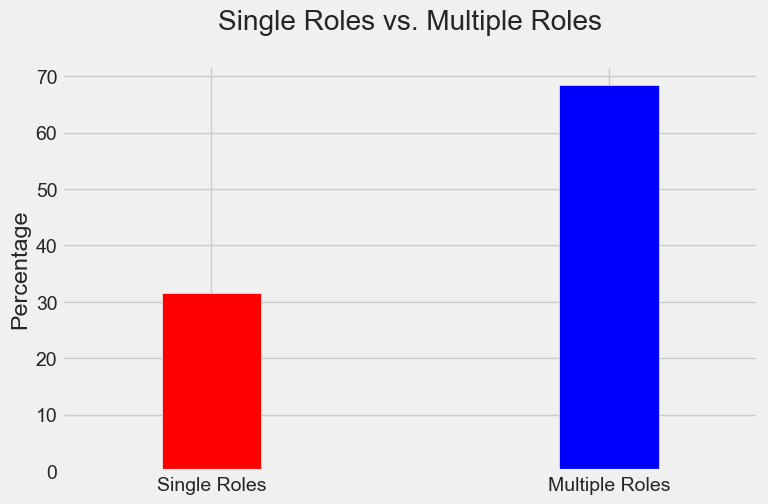

In [107]:
plt.style.use('fivethirtyeight')
roles.plot.bar(width=.25, rot=45, figsize=(8,5), color=['red', 'blue'])
plt.title('Single Roles vs. Multiple Roles', y=1.07)
plt.xticks([0,1],['Single Roles', 'Multiple Roles'], rotation=0)
plt.ylabel('Percentage')
plt.show()

Let's analyze the dataset to determine if a sample of those who are interested in web or mobile development sample is representative. In order to do this, we mut remove the nulls from the JobRoleInterest column (thereby creating a sample of the dataset) and analyze the records to determine if the sample represents our population of interest (new coders interested in web or mobile development).

In [108]:
jobs_no_nulls = df.loc[~df['JobRoleInterest'].isnull()]

Let's chart the difference between the coders interested in web and mobile development and those not interested.

In [109]:
mobile_web_other = (jobs_no_nulls['JobRoleInterest'].str.contains('Web Developer | Mobile Developer').value_counts(normalize=True) * 100)
mobile_web_other

False    67.048055
True     32.951945
Name: JobRoleInterest, dtype: float64

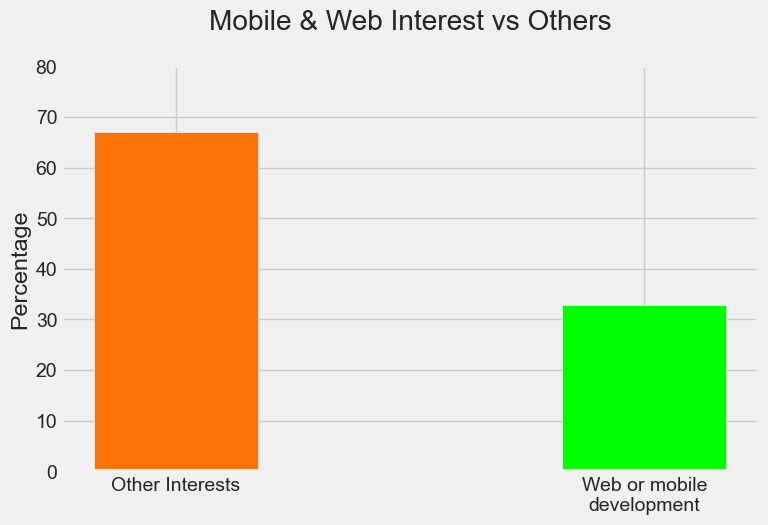

In [110]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,5))
plt.bar(mobile_web_other.index, mobile_web_other, width=.35, color=['#F97306', '#00FF00'])
plt.title('Mobile & Web Interest vs Others', y=1.07)
plt.xticks([0,1],['Other Interests', 'Web or mobile\ndevelopment'],
           rotation=0)
plt.ylabel('Percentage')
plt.ylim([0,80])
plt.show()

From the chart, slightly over 30% of the dataset is interested in mobile or web development.

We'll isolate this set for our analysis.

In [111]:
mobile_web_df = jobs_no_nulls.loc[jobs_no_nulls['JobRoleInterest'].str.contains('Web Developer | Mobile Developer')]
mobile_web_df.head()

,Age,AttendedBootcamp,BootcampFinish,BootcampLoanYesNo,BootcampName,BootcampRecommend,ChildrenNumber,CityPopulation,CodeEventConferences,CodeEventDjangoGirls,...,YouTubeFCC,YouTubeFunFunFunction,YouTubeGoogleDev,YouTubeLearnCode,YouTubeLevelUpTuts,YouTubeMIT,YouTubeMozillaHacks,YouTubeOther,YouTubeSimplilearn,YouTubeTheNewBoston
2,21.0,0.0,NaN,NaN,NaN,NaN,NaN,more than 1 million,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,20.0,0.0,NaN,NaN,NaN,NaN,NaN,"between 100,000 and 1 million",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,31.0,0.0,NaN,NaN,NaN,NaN,NaN,"less than 100,000",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,27.0,0.0,NaN,NaN,NaN,NaN,NaN,"between 100,000 and 1 million",NaN,NaN,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,37.0,0.0,NaN,NaN,NaN,NaN,NaN,"between 100,000 and 1 million",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### New Coders - Locations and Densities

Now that we've found out that the sample has the right categories of people for our purpose, we can begin analyzing it. We can start with finding out where these new coders are located, and what are the densities (how many coders there are) for each location.

The data set provides information about the location of each participant at a country level. The CountryLive variable describes what country each participant lives in. This is relevant to our analysis because we're interested in where people live when we run the ads.

Because the data set provides information at a country level, we can think of each country as an individual market. This means we can frame our goal as finding the two best countries to advertise in. One indicator of a good market is the number of potential customers — the more potential customers in a market, the better.

We'll generate and analyze absolute and relative frequency tables for the CountryLive variable.

In [112]:
mobile_web_df['CountryLive'].value_counts()

United States of America    1052
India                        173
United Kingdom               106
Canada                        88
Brazil                        43
                            ... 
Yemen                          1
Iran                           1
Senegal                        1
Georgia                        1
Gambia                         1
Name: CountryLive, Length: 105, dtype: int64

In [113]:
mobile_web_df['CountryLive'].value_counts(normalize=True)

United States of America    0.467140
India                       0.076821
United Kingdom              0.047069
Canada                      0.039076
Brazil                      0.019094
                              ...   
Yemen                       0.000444
Iran                        0.000444
Senegal                     0.000444
Georgia                     0.000444
Gambia                      0.000444
Name: CountryLive, Length: 105, dtype: float64

The top 2 markets are the US and Indian markets, which together account for 53% of users in the sample. We'll analyze further to determine customers who are willing to spend money on learning.

### Spending Money for Learning

We will continue our analysis by determining out how much money new coders are actually willing to spend on learning. Advertising within markets where most people are only willing to learn for free is extremely unlikely to be profitable for the business.

The MoneyForLearning column describes in USD the amount of money spent by participants from the moment they started coding until the moment they completed the survey. Our company sells subscriptions at a price of $59 per month, so we're interested in finding out how much money each student spends per month.

We will narrow our analysis to the top 4 countries where new coders live in the sample: the US, India, the United Kingdom, and Canada.

We'll create a new column that describes the amount of money a student has spent per month (at the moment they completed the survey).

In [114]:
(mobile_web_df['MonthsProgramming'] == 0).sum()

79

We'll convert null values to 1

In [115]:
mobile_web_df['MonthsProgramming'].loc[mobile_web_df['MonthsProgramming'] == 0] = 1

*can also use fcc_good['MonthsProgramming'].replace(0,1, inplace = True)*

Then we'll determine money spent per month for each learner.

In [116]:
(mobile_web_df['MonthsProgramming'] == 0.0).sum()

0

In [117]:
mobile_web_df['MonthsProgramming'].info()

<class 'pandas.core.series.Series'>
Int64Index: 2304 entries, 2 to 18171
Series name: MonthsProgramming
Non-Null Count  Dtype  
--------------  -----  
2171 non-null   float64
dtypes: float64(1)
memory usage: 36.0 KB


In [118]:
mobile_web_df['MoneyForLearningPerMonth'] = mobile_web_df['MoneyForLearning'] / mobile_web_df['MonthsProgramming']

mobile_web_df['MoneyForLearningPerMonth'].head()

2     200.000000
4       0.000000
19     17.857143
29           NaN
37           NaN
Name: MoneyForLearningPerMonth, dtype: float64

Let's find out how many null values there are in the new column.

In [119]:
mobile_web_df['MoneyForLearningPerMonth'].isna().sum()

231

Keep only the rows that don't have a null value for the new column.
and also in the CountryLive column.

In [120]:
clean_df = mobile_web_df.loc[~mobile_web_df['MoneyForLearningPerMonth'].isna() & ~mobile_web_df['CountryLive'].isna()]

clean_df = clean_df.loc[clean_df['CountryLive'].isin(['United States of America', 'India', 'United Kingdom', 'Canada'])]

clean_df[['MoneyForLearning', 'MonthsProgramming', 'MoneyForLearningPerMonth', 'CountryLive']].head()

,MoneyForLearning,MonthsProgramming,MoneyForLearningPerMonth,CountryLive
2,1000.0,5.0,200.000000,United States of America
19,500.0,28.0,17.857143,United States of America
40,200.0,8.0,25.000000,United States of America
52,0.0,12.0,0.000000,India
58,0.0,60.0,0.000000,India


The 0 values reflected in the MoneyForLearningPerMonth column reflects 0 values in the MoneyForLearning columns.

We'll group the remaining data by the CountryLive column and find out how much money a student spends on average each month in the US, India, the United Kingdom and Canada.

In [121]:
clean_df.groupby(by='CountryLive').agg({'MoneyForLearning':[np.average, np.median, pd.Series.mode]}).sort_values(by=('MoneyForLearning', 'average'), ascending=False)

MoneyForLearning            
                                  average median mode
CountryLive                                          
Canada                        1182.923077    0.0  0.0
United States of America      1019.976313   20.0  0.0
India                          523.143791    0.0  0.0
United Kingdom                 209.510870    0.0  0.0

In [122]:
clean_df.groupby(by='CountryLive').agg({'MoneyForLearningPerMonth':[np.average, np.median, pd.Series.mode]}).sort_values(by=('MoneyForLearningPerMonth', 'average'), ascending=False)

MoneyForLearningPerMonth            
                                          average median mode
CountryLive                                                  
United States of America               213.996364    2.5  0.0
India                                  168.010885    0.0  0.0
Canada                                 153.146140    0.0  0.0
United Kingdom                          41.448032    0.0  0.0

Canada is the country with the average highest total spend on learning, however, the USA and India spends more on average per month than Canada. The median ad mode across all the countries is \$0 except for the USA, which has a median average spend of \$2.50.

### Dealing with Extreme Outliers
The results for the United Kingdom and Canada are surprisingly low relative to the values we see for India. If we considered a few socio-economical metrics (like GDP per capita), we'd intuitively expect people in the UK and Canada to spend more on learning than people in India.

We'll generate boxplots to visualize for each country (the US, India, the United Kingdom, Canada) the distribution of the variable that describes how much money each participant had spent per month.

In [123]:
pattern = 'United States of America|India|United Kingdom|Canada'
money_per_month = clean_df.loc[clean_df['CountryLive'].str.contains(pattern)]
money_per_month.head()

,Age,AttendedBootcamp,BootcampFinish,BootcampLoanYesNo,BootcampName,BootcampRecommend,ChildrenNumber,CityPopulation,CodeEventConferences,CodeEventDjangoGirls,...,YouTubeFunFunFunction,YouTubeGoogleDev,YouTubeLearnCode,YouTubeLevelUpTuts,YouTubeMIT,YouTubeMozillaHacks,YouTubeOther,YouTubeSimplilearn,YouTubeTheNewBoston,MoneyForLearningPerMonth
2,21.0,0.0,NaN,NaN,NaN,NaN,NaN,more than 1 million,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,200.000000
19,31.0,0.0,NaN,NaN,NaN,NaN,NaN,"less than 100,000",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.857143
40,30.0,0.0,NaN,NaN,NaN,NaN,NaN,"less than 100,000",NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,Stephen Mayeux,NaN,1.0,25.000000
52,21.0,0.0,NaN,NaN,NaN,NaN,NaN,"between 100,000 and 1 million",NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.000000
58,21.0,0.0,NaN,NaN,NaN,NaN,NaN,more than 1 million,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,0.000000


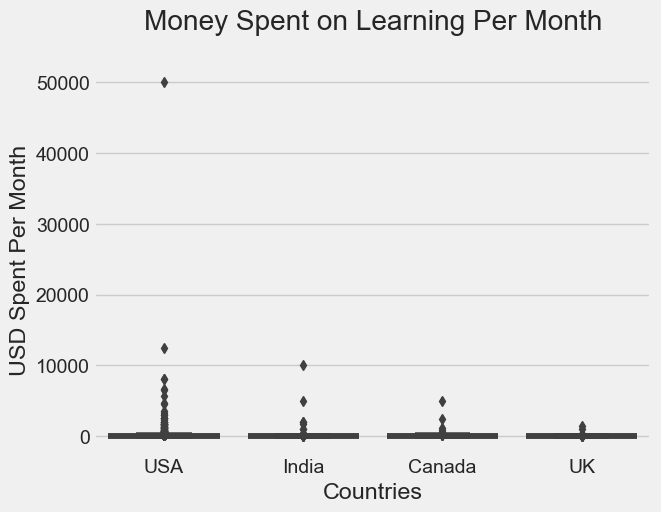

In [124]:
plt.style.use('fivethirtyeight')
plt.figure()
sns.boxplot(x='CountryLive', y='MoneyForLearningPerMonth', data=money_per_month, orient='vertical')
plt.title('Money Spent on Learning Per Month', y=1.07)
plt.xticks(range(4),['USA', 'India', 'Canada', 'UK'],
           rotation=0)
plt.xlabel('Countries')
plt.ylabel('USD Spent Per Month')
plt.show()

We can see that the US has extreme outliers. We'll eliminate them, compute the average values and plot again.

In [125]:
money_per_month = money_per_month.loc[money_per_month['MoneyForLearningPerMonth'] <= 10000]

In [126]:
money_per_month.groupby(by='CountryLive').agg({'MoneyForLearningPerMonth':[np.average, np.median, pd.Series.mode]}).sort_values(by=('MoneyForLearningPerMonth', 'average'), ascending=False)

MoneyForLearningPerMonth            
                                          average median mode
CountryLive                                                  
India                                  168.010885    0.0  0.0
Canada                                 153.146140    0.0  0.0
United States of America               149.938565    2.5  0.0
United Kingdom                          41.448032    0.0  0.0

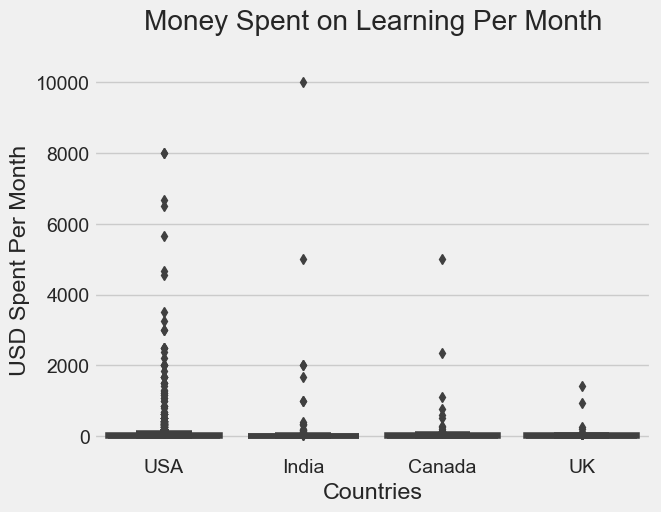

In [127]:
plt.style.use('fivethirtyeight')
plt.figure()
sns.boxplot(x='CountryLive', y='MoneyForLearningPerMonth', data=money_per_month, orient='vertical')
plt.title('Money Spent on Learning Per Month', y=1.07)
plt.xticks(range(4),['USA', 'India', 'Canada', 'UK'],
           rotation=0)
plt.xlabel('Countries')
plt.ylabel('USD Spent Per Month')
plt.show()

There are a few extreme outliers for India. We'll isolate them and identify why they may be outliers.

In [128]:
money_per_month.loc[(money_per_month['CountryLive'] == 'India') & (money_per_month['MoneyForLearningPerMonth'] > 2000)]

,Age,AttendedBootcamp,BootcampFinish,BootcampLoanYesNo,BootcampName,BootcampRecommend,ChildrenNumber,CityPopulation,CodeEventConferences,CodeEventDjangoGirls,...,YouTubeFunFunFunction,YouTubeGoogleDev,YouTubeLearnCode,YouTubeLevelUpTuts,YouTubeMIT,YouTubeMozillaHacks,YouTubeOther,YouTubeSimplilearn,YouTubeTheNewBoston,MoneyForLearningPerMonth
1728,24.0,0.0,NaN,NaN,NaN,NaN,NaN,"between 100,000 and 1 million",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000.0
13398,19.0,0.0,NaN,NaN,NaN,NaN,NaN,more than 1 million,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.0


From our review of the records, there seems no clear rationale for the total money spent / money spent per month. These values may represent errors. We will remove them from the dataset, compute mean and replot.

In [129]:
money_per_month.drop(money_per_month.loc[(money_per_month['CountryLive'] == 'India') & (money_per_month['MoneyForLearningPerMonth'] > 2000)].index, inplace=True)

In [130]:
money_per_month.groupby(by='CountryLive').agg(
    {'MoneyForLearningPerMonth': [np.average, np.median, pd.Series.mode]}).sort_values(
    by=('MoneyForLearningPerMonth', 'average'), ascending=False)

MoneyForLearningPerMonth            
                                          average median mode
CountryLive                                                  
Canada                                 153.146140    0.0  0.0
United States of America               149.938565    2.5  0.0
India                                   70.898446    0.0  0.0
United Kingdom                          41.448032    0.0  0.0

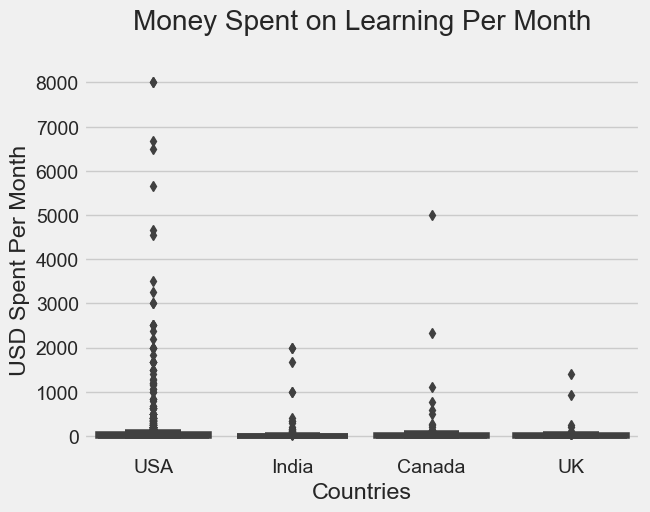

In [131]:
plt.style.use('fivethirtyeight')
plt.figure()
sns.boxplot(x='CountryLive', y='MoneyForLearningPerMonth', data=money_per_month, orient='vertical')
plt.title('Money Spent on Learning Per Month', y=1.07)
plt.xticks(range(4),['USA', 'India', 'Canada', 'UK'],
           rotation=0)
plt.xlabel('Countries')
plt.ylabel('USD Spent Per Month')
plt.show()

After removing the outliers, the Indian average has dropped by more than half to \$70.

We'll perform the above operations on the Canadian records and analyze.

In [132]:
money_per_month.loc[(money_per_month['CountryLive'] == 'Canada') & (money_per_month['MoneyForLearningPerMonth'] > 2000)]

,Age,AttendedBootcamp,BootcampFinish,BootcampLoanYesNo,BootcampName,BootcampRecommend,ChildrenNumber,CityPopulation,CodeEventConferences,CodeEventDjangoGirls,...,YouTubeFunFunFunction,YouTubeGoogleDev,YouTubeLearnCode,YouTubeLevelUpTuts,YouTubeMIT,YouTubeMozillaHacks,YouTubeOther,YouTubeSimplilearn,YouTubeTheNewBoston,MoneyForLearningPerMonth
6590,20.0,1.0,1.0,0.0,Lighthouse Labs,1.0,NaN,more than 1 million,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2337.166667
13659,24.0,1.0,0.0,0.0,Bloc.io,1.0,NaN,more than 1 million,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,5000.000000


There are also 2 outliers here with monthly spend in excess of \$2000. However, these outliers are explained becasue they attended bootcamps. Bootcamps are usually more expensive than other courses. One of the records has completed their bootcamp and the other has not.

We'll therefore drop the record of the uncompleted bootcamp to get a clearer picture of average spend per month.

In [133]:
money_per_month.drop(money_per_month.loc[(money_per_month['CountryLive'] == 'Canada') & (money_per_month['MoneyForLearningPerMonth'] > 3000)].index, inplace=True)

money_per_month.groupby(by='CountryLive').agg(
    {'MoneyForLearningPerMonth': [np.average, np.median, pd.Series.mode]}).sort_values(
    by=('MoneyForLearningPerMonth', 'average'), ascending=False)

MoneyForLearningPerMonth            
                                          average median mode
CountryLive                                                  
United States of America               149.938565    2.5  0.0
Canada                                  90.199986    0.0  0.0
India                                   70.898446    0.0  0.0
United Kingdom                          41.448032    0.0  0.0

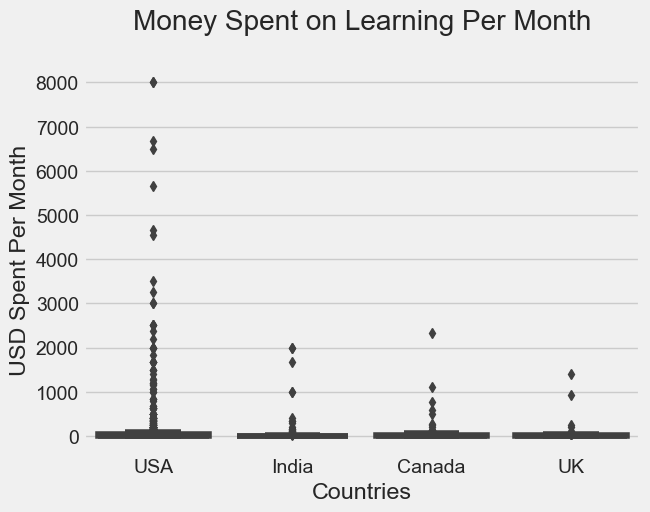

In [134]:
plt.style.use('fivethirtyeight')
plt.figure()
sns.boxplot(x='CountryLive', y='MoneyForLearningPerMonth', data=money_per_month, orient='vertical')
plt.title('Money Spent on Learning Per Month', y=1.07)
plt.xticks(range(4),['USA', 'India', 'Canada', 'UK'],
           rotation=0)
plt.xlabel('Countries')
plt.ylabel('USD Spent Per Month')
plt.show()

We'll perform final cleaning on the US records.

In [135]:
money_per_month.loc[(money_per_month['CountryLive'] == 'United States of America') & (money_per_month['MoneyForLearningPerMonth'] > 5000)]

,Age,AttendedBootcamp,BootcampFinish,BootcampLoanYesNo,BootcampName,BootcampRecommend,ChildrenNumber,CityPopulation,CodeEventConferences,CodeEventDjangoGirls,...,YouTubeFunFunFunction,YouTubeGoogleDev,YouTubeLearnCode,YouTubeLevelUpTuts,YouTubeMIT,YouTubeMozillaHacks,YouTubeOther,YouTubeSimplilearn,YouTubeTheNewBoston,MoneyForLearningPerMonth
718,26.0,1.0,0.0,0.0,The Coding Boot Camp at UCLA Extension,1.0,NaN,more than 1 million,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8000.000000
1222,32.0,1.0,0.0,0.0,The Iron Yard,1.0,NaN,"between 100,000 and 1 million",NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6500.000000
3145,34.0,1.0,0.0,0.0,Hackbright Academy,1.0,NaN,"between 100,000 and 1 million",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5666.666667
7505,26.0,1.0,0.0,1.0,Codeup,0.0,NaN,more than 1 million,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,6666.666667
9778,33.0,1.0,0.0,1.0,Grand Circus,1.0,NaN,"between 100,000 and 1 million",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8000.000000


All the records from the US with spend per month above \$5000 are bootcamp attendees who have been programming for less than 3 months and have not completed their bootcamps. We'll drop these rows to get a clearer view on average spend from the US.

In [136]:
money_per_month.drop(money_per_month.loc[(money_per_month['CountryLive'] == 'United States of America') & (money_per_month['MoneyForLearningPerMonth'] > 5000)].index, inplace=True)

money_per_month.groupby(by='CountryLive').agg(
    {'MoneyForLearningPerMonth': [np.average, np.median, pd.Series.mode]}).sort_values(
    by=('MoneyForLearningPerMonth', 'average'), ascending=False)

MoneyForLearningPerMonth            
                                          average median mode
CountryLive                                                  
United States of America               114.582092    2.5  0.0
Canada                                  90.199986    0.0  0.0
India                                   70.898446    0.0  0.0
United Kingdom                          41.448032    0.0  0.0

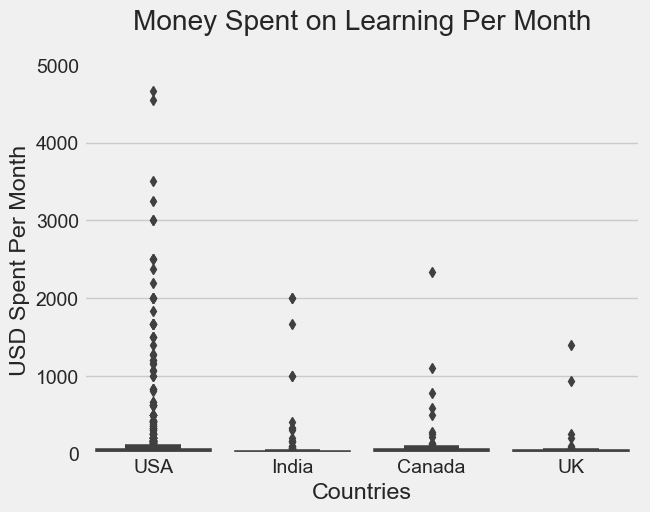

In [137]:
plt.style.use('fivethirtyeight')
plt.figure()
sns.boxplot(x='CountryLive', y='MoneyForLearningPerMonth', data=money_per_month, orient='vertical')
plt.title('Money Spent on Learning Per Month', y=1.07)
plt.xticks(range(4),['USA', 'India', 'Canada', 'UK'],
           rotation=0)
plt.ylim(0,5000)
plt.xlabel('Countries')
plt.ylabel('USD Spent Per Month')
plt.show()

After this cleaning exercise, it seems that the best countries for advertisement are the United States & Canada. We'll analyze further below.

### Choosing the Two Best Markets
At \$59 a month, advertising in any of the top 3 markets seems to be a viable option. We'll use a frequency table to see how each country is represented in the dataset in order to determine which of them top 3 should be in our 2 markets.

In [138]:
money_per_month['CountryLive'].value_counts(normalize=True) * 100

United States of America    75.077882
India                       11.760125
United Kingdom               7.165109
Canada                       5.996885
Name: CountryLive, dtype: float64

With 75% of the dataset represented and an average monthly spend of \$114, the US should be our top advertisement market.

Choosing between India and Canada is a lot less clear. India has the second-highest representation in our dataset (11%) but the third-highest amount spent per month (\$70 on average). Canada is the opposite, with 6% representation in the dataset and \$90 average monthly spend.

Given the spread between Canada and India, it is a viable option to advertise in both countries as well. India will provide more spenders and Canada will provide higher spending averages.

The budget spend should be split 70:30 (or 60:40) with 70% going to the US and 30% split equally between Canada and India. This reflects representation and average spend. The marketing team may opt to advertise only in the US market. The market is large enough and has enough spending capacity to support such a decision.

It is in our best interest to share our results with the marketing team who have domain expertise to take the best decision.

### Next Steps
Next steps include:
* Finding other criteria for choosing the best market.
* Analyzing other data sets:
* * freeCodeCamp's 2016 New Coders Survey.
* * Stack Overflow 2018 Developer Survey.